In [5]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram
from neuropy.io.usvio import detect_tone

from tracefc.io.session_directory import get_session_dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [7]:
animal, sess_name = 'Han', 'training'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [8]:
print(sess.eegfile)

duration: 12444.12 seconds 
duration: 3.46 hours 



# DeepLabCut

In [9]:
import neuropy.io.dlcio as dlcio
dlc_path = '/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training'
arena_side_pix = 60  # Keep this
arena_side_cm = 25.4  # Update this after measuring!!!
pix2cm = arena_side_cm / arena_side_pix

# Read in DLC data
sess.dlc = dlcio.DLC(dlc_path, pix2cm=pix2cm)

# Smooth position, get timestamps, and get speed
sess.dlc.get_timestamps('ms_webcam', include_str="2_training")
sess.dlc.smooth_pos(bodyparts=["crown_middle", "back_middle"])
sess.dlc.timestamps["Timestamps"] = sess.dlc.timestamps["Timestamps"].dt.tz_localize("America/Detroit")
sess.dlc.get_all_speed()

Using tracking file #1: /data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/2_training/training/Han/gobears/2022_08_03/12_36_08/My_WebCam/Han_training_combined_movieDLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5
Using tracking file #2: /data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/2_training/training/Han/gobears/2022_08_03/12_56_53/My_WebCam/Han_training_combined_movie2DLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5
Multiple videos found - taking mean sample rate from all videos


,back_middle,crown_middle,left_ear,neck_base,nose,right_ear,tail_base,tail_end,tail_middle
0,NaN,NaN,0.949496,2.045391,0.514713,522.352469,2.309584,2.733619,797.835039
1,NaN,NaN,0.640402,3.409019,947.665678,618.566829,0.762817,36.962826,951.034649
2,NaN,NaN,1.364747,1.724073,9.313889,5.699983,1.175630,6.141868,8.528459
3,NaN,NaN,1.576331,1.492093,3.701812,2.763913,0.732941,3.522559,7.967008
4,NaN,NaN,0.817776,6.712119,1293.656959,615.051174,3.735422,8.239001,163.852439
...,...,...,...,...,...,...,...,...,...
47149,NaN,NaN,1.656170,1.045737,0.801105,2.077901,2.830298,2.976562,3.469482
47150,NaN,NaN,1.358740,1.636843,2.992546,3.484092,2.565242,2.823081,104.019311
47151,NaN,NaN,1.604366,0.949890,2.634357,0.372942,1.338121,1.548268,82.753621
47152,NaN,NaN,2.701421,2.157277,2.666349,2.432953,0.646449,1.647844,0.444972


In [10]:
# Load in openephys times to sync
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Total seconds from start"] = (sync_df["Datetime"] - sync_df["Datetime"][0]).dt.total_seconds()

# sync DLC times to your eeg file
sess.dlc.timestamps["Total seconds from OE start"] = (sess.dlc.timestamps["Timestamps"] - sync_df["Datetime"][0]).dt.total_seconds()
sess.dlc.timestamps["eeg_time"] = np.interp(sess.dlc.timestamps["Total seconds from OE start"], sync_df["Total seconds from start"], 
                                            sync_df["eeg_time"])
sess.dlc.timestamps

start time = 2022-08-03 12:25:29.361157-04:00
start time = 2022-08-03 12:28:50.720333-04:00
start time = 2022-08-03 12:35:21.719327-04:00
start time = 2022-08-03 12:53:02.683128-04:00
start time = 2022-08-03 12:56:48.234187-04:00
start time = 2022-08-03 13:10:55.680961-04:00
start time = 2022-08-03 13:14:13.174881-04:00
start time = 2022-08-03 13:16:44.696588-04:00
start time = 2022-08-03 13:35:23.930035-04:00
start time = 2022-08-03 14:25:45.955674-04:00
start time = 2022-08-03 14:34:34.738770-04:00
start time = 2022-08-03 15:19:53.342091-04:00
start time = 2022-08-03 15:42:32.218764-04:00


,Frame Number,Time Stamp (ms),Buffer Index,Timestamps,Total seconds from OE start,eeg_time
0,0,-23,3,2022-08-03 12:36:08.552000-04:00,639.190843,463.771826
1,1,29,3,2022-08-03 12:36:08.604000-04:00,639.242843,463.823826
2,2,73,2,2022-08-03 12:36:08.648000-04:00,639.286843,463.867826
3,3,105,1,2022-08-03 12:36:08.680000-04:00,639.318843,463.899826
4,4,153,0,2022-08-03 12:36:08.728000-04:00,639.366843,463.947826
...,...,...,...,...,...,...
18031,18031,754001,0,2022-08-03 13:09:27.457000-04:00,2638.095843,2408.159915
18032,18032,754043,0,2022-08-03 13:09:27.499000-04:00,2638.137843,2408.201915
18033,18033,754081,0,2022-08-03 13:09:27.537000-04:00,2638.175843,2408.239915
18034,18034,754129,0,2022-08-03 13:09:27.585000-04:00,2638.223843,2408.287915


In [11]:
# Last calculate freezing times and plot again to check
frz_thresh = 0.25 # cm/sec  Adjust this to something that looks reasonable!
duration_thresh = 1 # sec, must be below the threshold above for at least that long to be considered freezing
bodypart_use = "crown_middle"
frz_bool = sess.dlc.speed[bodypart_use] < frz_thresh
frz_epochs = Epoch.from_boolean_array(frz_bool, t=sess.dlc.timestamps["eeg_time"])
frz_df = frz_epochs.to_dataframe()
frz_df = frz_df[frz_epochs.durations > duration_thresh]
frz_epochs = Epoch(frz_df)
frz_epochs

186 epochs
Snippet: 
         start        stop  duration label
0  634.067654  635.195653  1.127999  high
1  653.050634  654.267633  1.216999  high
2  669.226618  670.410617  1.183999  high
3  709.002578  712.730574  3.727996  high
4  714.810572  716.410570  1.599998  high

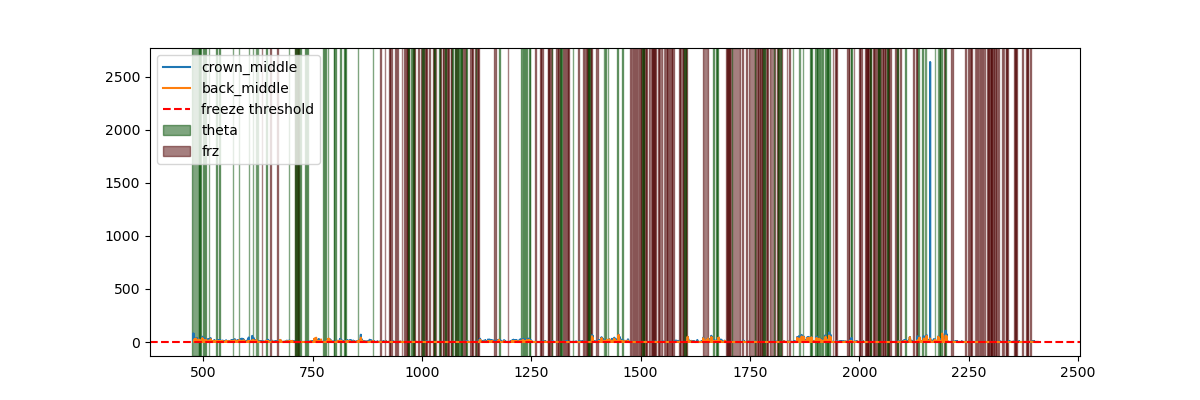

In [12]:
%matplotlib widget
# Plot to check! Looks ok, though there might be some mismatches between theta and movement.

_, ax = plt.subplots(figsize=(12, 4))
hc, = ax.plot(sess.dlc.timestamps["eeg_time"], sess.dlc.speed["crown_middle"])
hb, = ax.plot(sess.dlc.timestamps["eeg_time"], sess.dlc.speed["back_middle"])
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5])

# Now plot theta epochs over it to triple check!
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start = sess.dlc.timestamps["eeg_time"].min(), t_stop=sess.dlc.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])

ax.legend((hc, hb, hthresh, htheta, hf), ("crown_middle", "back_middle", "freeze threshold", "theta", "frz"))

,channel_states,timestamps,datetimes,event_name
615,2,2376226,2022-08-03 12:26:48.207533333,
716,-2,2673758,2022-08-03 12:26:58.125266667,
1234,2,4226403,2022-08-03 12:27:49.880100000,
1335,-2,4524446,2022-08-03 12:27:59.814866667,
93,2,279173,2022-08-03 12:28:59.305766667,


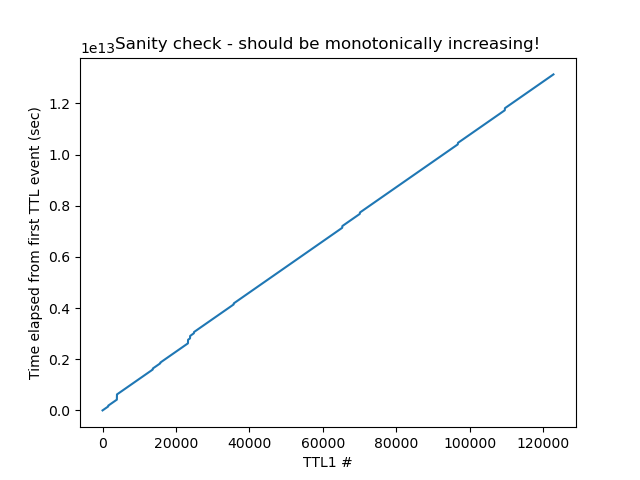

In [13]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

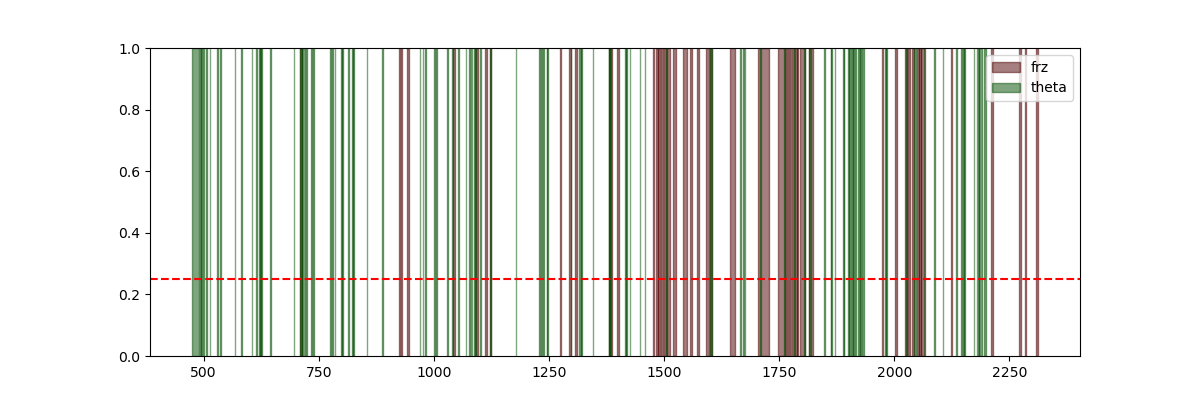

In [14]:
#Freezing and theta
from copy import deepcopy

manually_adjust_dlc_times = -0.528  
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 3:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs = Epoch(epochs=None, file=beta_epochs_file)
beta_epochs = beta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5], label='theta')
    
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

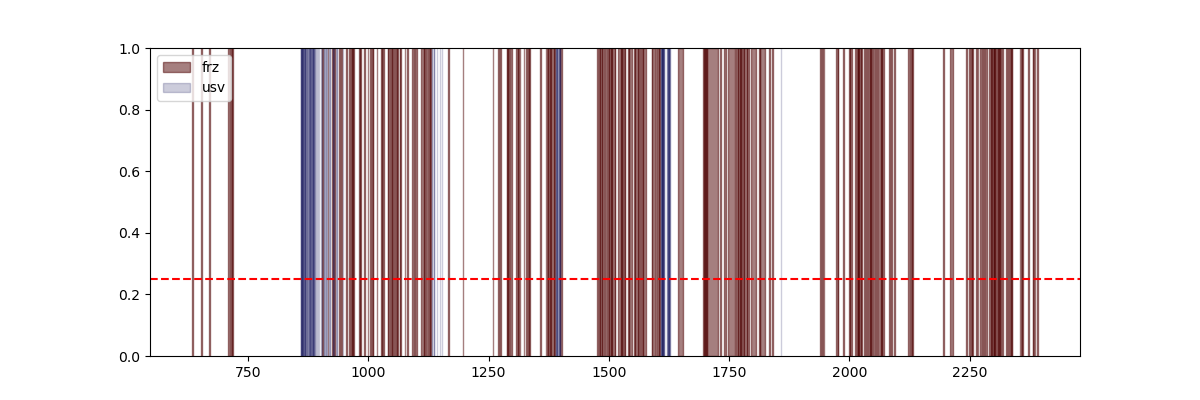

In [24]:
#Freezing and USV
from copy import deepcopy

manually_adjust_dlc_times = -0.528 
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start

    if duration > 1:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

# theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
# theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
# theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs


# delta_epochs_file = sess.filePrefix.with_suffix(".delta_epochs.npy")
# delta_epochs = Epoch(epochs=None, file=delta_epochs_file)
# delta_epochs = delta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

    
for start, stop in zip(usv_epochs._epochs.t_start_eeg, usv_epochs._epochs.t_stop_eeg):
    duration = stop-start

    husv = ax.axvspan(start, stop, color=[0, 0, 0.3, 0.2], label='usv')
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

In [17]:
usv_epochs

107 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  446.819063  446.912341  446.819063  32.435751  0.093278   45.195929    1.0   
1  446.917153  446.991495  446.917153  50.405216  0.074342   34.441476    1.0   
2  447.052188  447.165813  447.052188  43.482818  0.113625   16.668958    1.0   
3  447.256451  447.308525  447.256451  46.914662  0.052074   11.521191    1.0   
4  447.305980  447.444434  447.305980  32.451890  0.138454    9.315006    1.0   

   Accept  nrec  t_start_eeg  t_stop_eeg label  
0       1     2   860.598041  860.691307        
1       1     2   860.696118  860.770450        
2       1     2   860.831136  860.944746        
3       1     2   861.035373  861.087440        
4       1     2   861.084896  861.223332        

## Save notebook to animal working directory

In [5]:
from neuropy.utils.manipulate_files import save_notebook
try:
    save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")
except PermissionError:
    print('Got a weird PermissionError. Check to make sure file saved successfully')

/data/GitHub/TraceFC/Notebooks/Animal_files/Sync_USV_and_Ephys(Han).ipynb saved to /data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training_Sync_USV_and_Ephys(Han).ipynb


### Load in disconnect and motion artifacts

In [6]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=31), thresh=11, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 109.1 seconds


/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,start,stop,label,duration
0,159.7436,170.1324,None,10.3888
1,408.2588,417.1892,None,8.9304
2,859.7700,861.2836,None,1.5136
3,1131.6012,1133.1612,None,1.5600
4,1388.3636,1389.8148,None,1.4512
5,1428.2516,1440.1052,None,11.8536
6,1606.8492,1608.3668,None,1.5176
7,1857.1372,1858.7028,None,1.5656
8,2132.0428,2133.4652,None,1.4224
9,2508.8548,2516.5156,None,7.6608


<Axes: >

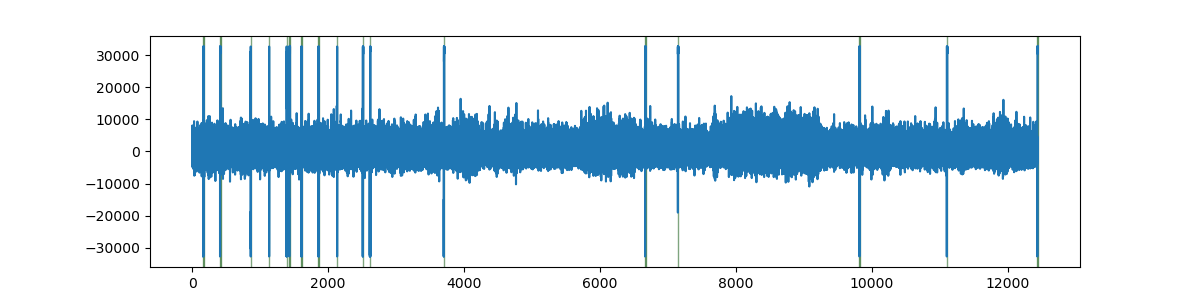

In [7]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.probegroup.npy saved


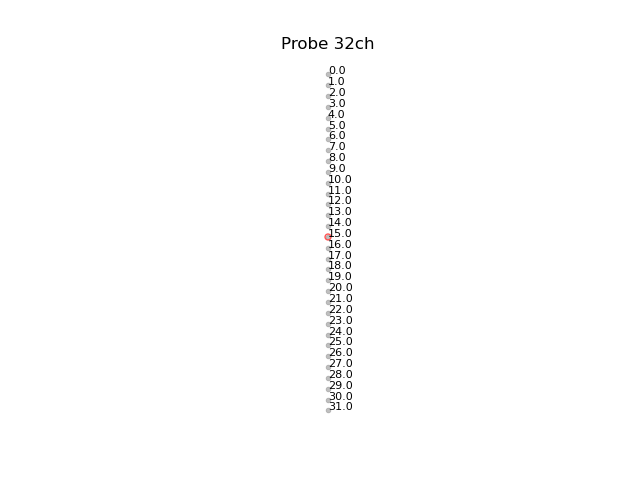

In [8]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

## Detect Theta epochs

In [9]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 8

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for theta: [8]
960 epochs remaining with durations within (1,20)


## Detect SWR Epochs

In [10]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 8
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


Selected channels for ripples: [8]
8013 epochs remaining with durations within (0.05,0.45)


# Detect Delta

In [11]:
#Detect Delta
from neuropy.analyses.oscillations import detect_hpc_delta_wave_epochs
min_dur = 0.15  
max_dur = 0.5   
ignore_epochs = None  
delta_channel = 8 

freq_band = (0.5, 4)

if delta_channel is not None:
    signal_use = signal.time_slice(channel_id=delta_channel)
else:
    signal_use = signal
delta_epochs = detect_hpc_delta_wave_epochs(
    signal_use, freq_band=freq_band, min_dur=min_dur, max_dur=max_dur, ignore_epochs=ignore_epochs
)

322 delta waves detected


In [12]:
#Detect Beta
from neuropy.analyses.oscillations import detect_beta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
beta_channel = 8
  
if beta_channel is None:
    beta_epochs, beta_power = detect_beta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=beta_channel)
    beta_epochs, beta_power = detect_beta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for beta: [8]
874 epochs remaining with durations within (1,20)


In [13]:
# Detect Gamma
from neuropy.analyses.oscillations import detect_gamma_epochs
from neuropy.analyses.oscillations import Gamma
band=(40, 80)
lowthresh = 1.5  
highthresh = 3 
minDistance = 300
minDuration = 125
gamma_channel = 8

# Use this if you don't know the specific channel for gamma detection
if gamma_channel is None:
    signal_use = signal.time_slice(channel_id=gamma_channel)
else:
    # If a specific channel for gamma is known
    signal_use = signal

gammadetect = Gamma()
# gammadetect.get_peak_intervals(signal.traces, lowthresh=lowthresh, highthresh=highthresh, minDistance=minDistance, minDuration=minDuration)
peakevents, gamma_amp = Gamma().get_peak_intervals(signal_use.traces[gamma_channel, :], band=band, lowthresh=lowthresh, highthresh=highthresh, 
                                        minDistance=minDistance, minDuration=minDuration, return_amplitude=True)
# csd=csd(self, period, refchan, band=band, window=1250)
gamma_epochs = Epoch(pd.DataFrame({"start" : peakevents[:, 0]/sess.eegfile.sampling_rate, "stop": peakevents[:, 1]/sess.eegfile.sampling_rate,
                   "label": ""}))
# pd.DataFrame(dict(start=peakevents[:, 0]/sess.eegfile.sampling_rate, stop=peakevents[:, 1]/sess.eegfile.sampling_rate))

In [14]:
gamma_epochs

27 epochs
Snippet: 
        start       stop label
0   159.9664   160.0864      
1   161.3648   161.5592      
2   408.4640   408.6048      
3   859.8856   861.2280      
4  1131.7848  1132.9344      

## Sync via CS+ or CS- times in tone_recall or control_tone_recall or tone_habituation session

,channel_states,timestamps,datetimes,event_name
615,2,2376226,2022-08-03 12:26:48.207533333,
716,-2,2673758,2022-08-03 12:26:58.125266667,
1234,2,4226403,2022-08-03 12:27:49.880100000,
1335,-2,4524446,2022-08-03 12:27:59.814866667,
93,2,279173,2022-08-03 12:28:59.305766667,


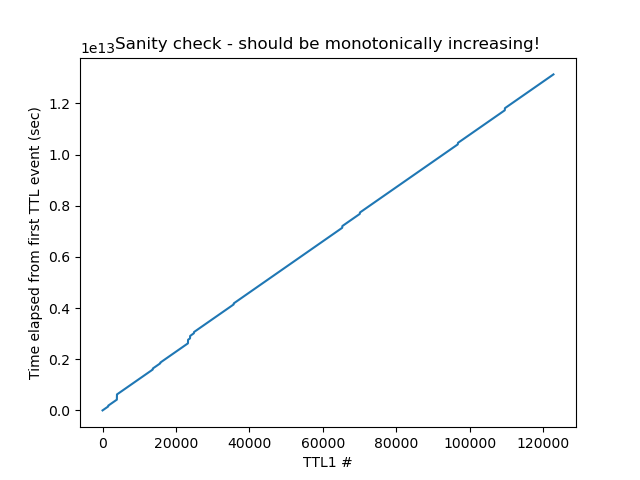

In [15]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [16]:
import tracefc.io.traceio as traceio

if "training" in str(sess.basepath):
    # For tone habituation
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))
    
    # For CS+ during training
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="training", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
elif "recall" in str(sess.basepath):
    # For tone recall CS+
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
    
    # For control tone recall CS-
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))

    # For control tone recall CS+(2)
    cs2_starts, cs2_stops, cs2_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs2_starts.shape[0]} CS+(2) events detected')
    print(cs2_starts.head(6))
elif "habituation" in str(sess.basepath):
     # For tone habituation
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))

5 CS- events detected
      Time (s)      Event                     Timestamp
5    61.611391  CS1_start 2022-08-03 12:26:48.547290068
7   123.284284  CS2_start 2022-08-03 12:27:50.220183353
9   193.079082  CS3_start 2022-08-03 12:29:00.014981489
11  273.033481  CS4_start 2022-08-03 12:30:19.969380121
13  344.838630  CS5_start 2022-08-03 12:31:31.774529438
6 CS+ events detected
       Time (s)      Event                     Timestamp
10   365.884472  CS1_start 2022-08-03 12:42:14.453900370
20   637.729703  CS2_start 2022-08-03 12:46:46.299130950
30   894.384018  CS3_start 2022-08-03 12:51:02.953446421
40  1150.995409  CS4_start 2022-08-03 12:55:19.564837250
50  1417.781024  CS5_start 2022-08-03 12:59:46.350451502
60  1692.700537  CS6_start 2022-08-03 13:04:21.269964728


In [17]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2022-08-03 12:25:29.361157-04:00
start time = 2022-08-03 12:28:50.720333-04:00
start time = 2022-08-03 12:35:21.719327-04:00
start time = 2022-08-03 12:53:02.683128-04:00
start time = 2022-08-03 12:56:48.234187-04:00
start time = 2022-08-03 13:10:55.680961-04:00
start time = 2022-08-03 13:14:13.174881-04:00
start time = 2022-08-03 13:16:44.696588-04:00
start time = 2022-08-03 13:35:23.930035-04:00
start time = 2022-08-03 14:25:45.955674-04:00
start time = 2022-08-03 14:34:34.738770-04:00
start time = 2022-08-03 15:19:53.342091-04:00
start time = 2022-08-03 15:42:32.218764-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2022-08-03 12:25:29.361157-04:00,start,0,0.000000,0,0.0000
1,0,2022-08-03 12:28:19.242723667-04:00,stop,5096447,169.881567,212351,169.8808
2,1,2022-08-03 12:28:50.720333-04:00,start,5096448,169.881600,212352,169.8816
3,1,2022-08-03 12:32:57.777366333-04:00,stop,12508159,416.938633,521173,416.9384
4,2,2022-08-03 12:35:21.719327-04:00,start,12508160,416.938667,521174,416.9392
5,2,2022-08-03 12:52:24.635560333-04:00,stop,43195647,1439.854900,1799818,1439.8544
6,3,2022-08-03 12:53:02.683128-04:00,start,43195648,1439.854933,1799819,1439.8552
7,3,2022-08-03 12:56:31.765494667-04:00,stop,49468119,1648.937300,2061171,1648.9368
8,4,2022-08-03 12:56:48.234187-04:00,start,49468120,1648.937333,2061172,1648.9376
9,4,2022-08-03 13:09:30.277887-04:00,stop,72329431,2410.981033,3013726,2410.9808


In [18]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = pd.Timedelta(0.8, unit="seconds")
cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
cs_oe_stop_df = traceio.trace_ttl_to_openephys(cs_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
# Convert to times in combined eeg file
cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)
cs_stops_combined = oeio.recording_events_to_combined_time(cs_oe_stop_df, sync_df)

csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)
csn_oe_stop_df = traceio.trace_ttl_to_openephys(csn_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)
csn_stops_combined = oeio.recording_events_to_combined_time(csn_oe_stop_df, sync_df)

start time lag: mean = -0.5394885366666666, std = 0.2466135352632615
start time lag: mean = -0.539772271, std = 0.24672374012407294
start time lag: mean = -0.561666227, std = 0.20242577000755455
start time lag: mean = -0.5619773967999999, std = 0.20256404992101418


/data/GitHub/TraceFC/tracefc/io/traceio.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace_cs_sync_df.loc[:, "datetimes"] = trace_cs_sync_df["datetimes"].dt.tz_localize(


### How to write CS+ to neuroscope event file

In [19]:
cs_tone_recall_epochs = Epoch({"start": cs_starts_combined, "stop": cs_stops_combined, "label": ["CS+"]*len(cs_starts_combined)})
cs_tone_recall_epochs
sess.recinfo.write_epochs(cs_tone_recall_epochs, "cs+")

/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/2_training/shockbox/T0000001.wav
Mean start lag time of 389.452 sec with std = 24.982 sec. Add lags from wavfile times to get ephys times
Mean stop lag time of 389.250 sec with std = 24.983 sec.


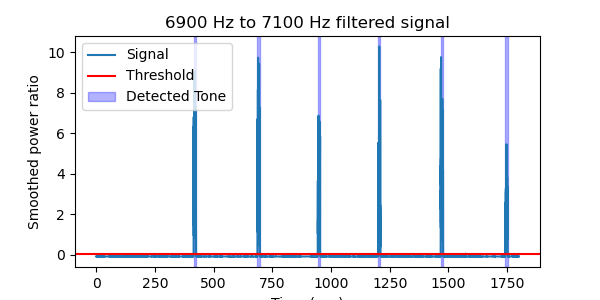

In [20]:
# Detect CS+ in audio recording.
from tracefc.io.traceio import grab_usv_folder
csp_wav = grab_usv_folder(sess.basepath, 'csp')
print(csp_wav)
# Get CS+ times and plot to check
cs_wav_epochs, cs_wav_stop = detect_tone(csp_wav, freq_lims=(6900, 7100), thresh=0.05, tone_length=10, tone_label="CS+", 
                                         plot_check=True, return_stop=True)
# Check that lags are consistent
cs_start_lags = cs_starts_combined - cs_wav_epochs.starts
print(f"Mean start lag time of {np.mean(cs_start_lags):0.3F} sec with std = {np.std(cs_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
cs_stop_lags = cs_stops_combined - cs_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(cs_stop_lags):0.3F} sec with std = {np.std(cs_stop_lags):0.3F} sec.")

Ditto for CS-

/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/1_tone_habituation/tone_habit_box/T0000002.wav
No tones detected at thresh=0.1 and length=10. Adjust power/time thresholds and re-run


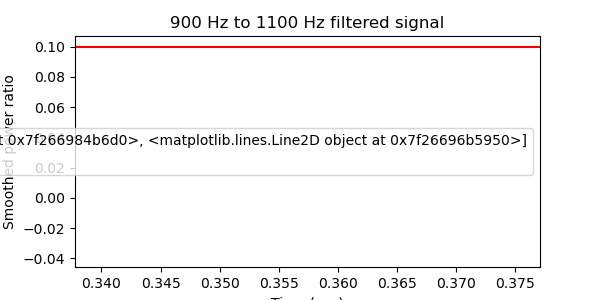

In [21]:
# Detect CS- in audio recording.
csn_wav = grab_usv_folder(sess.basepath, 'csn')
print(csn_wav)

# Get CS+ times and plot to check
csn_wav_epochs, csn_wav_stop = detect_tone(csn_wav, freq_lims=(900, 1100), thresh=0.1, tone_length=10, tone_label="CS-", 
                                           plot_check=True, return_stop=True)

# Check that lags are consistent
#csn_start_lags = csn_starts_combined - csn_wav_epochs.starts
#print(f"Mean start lag time of {np.mean(csn_start_lags):0.3F} sec with std = {np.std(csn_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
#csn_stop_lags = csn_stops_combined - csn_wav_epochs.stops
#print(f"Mean stop lag time of {np.mean(csn_stop_lags):0.3F} sec with std = {np.std(csn_stop_lags):0.3F} sec.")

Now try to sync to start tone 

/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/3_post/rest_box/T0000003.wav


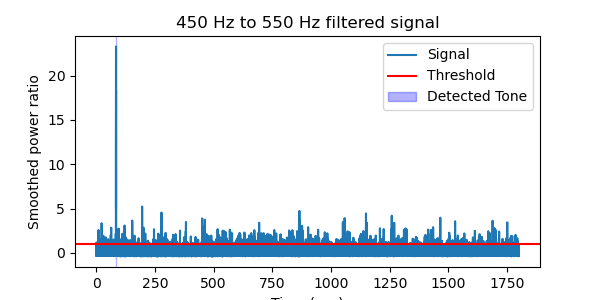

In [22]:
no_tone_wav = grab_usv_folder(sess.basepath, "sync")
print(no_tone_wav)

#Get CS+ times and plot to check
start_wav_epochs, start_wav_stop = detect_tone(no_tone_wav, freq_lims=(450, 550), thresh=1, tone_length=0.5, tone_label="start_tone", 
                               plot_check=True, return_stop=True)

## Sync recorded USV times to ephys file

In [23]:
# Read in USV times from tone recall session
from neuropy.io.usvio import DeepSqueakIO
usv_detect_file = sorted(Path(csp_wav).parent.glob(f"**/{Path(csp_wav).name[:-4]}*_cell.mat"))[0]

ds_calls = DeepSqueakIO(filename=usv_detect_file)
ds_calls.load_calls()
ds_calls.usv_df.sample(5)

,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept
22,459.151268,28.055556,0.100000,19.839633,0.590221,1
4,447.305980,32.451890,0.138454,9.315006,1.000000,1
34,467.213248,28.942434,0.144755,6.218202,1.000000,1
53,494.901268,13.625000,0.287955,11.227806,0.590221,1
97,1246.113960,15.592471,0.454524,5.555556,1.000000,1


Plot lags vs time to check for drift between ephys and audio recordings and correct if necessary

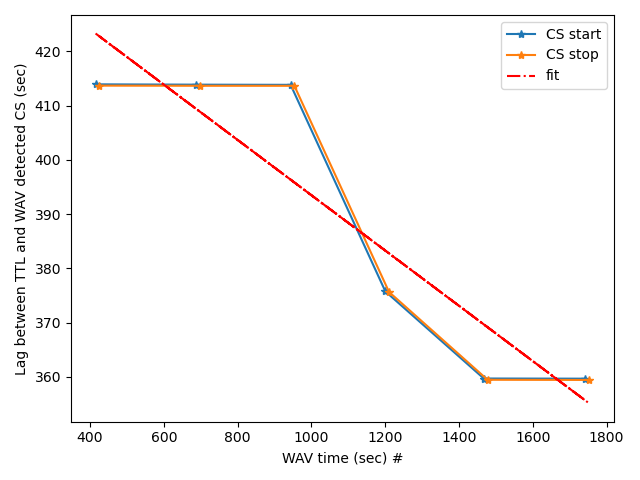

In [24]:
from scipy.linalg import lstsq

_, ax = plt.subplots(layout='tight')
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)
hl = ax.plot(cs_times_wav, cs_lags_comb, '*-')
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = cs_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(cs_lags_comb.reshape(-1)), cs_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
hfit = ax.plot(cs_times_wav.T.reshape(-1), p[0] + p[1]*cs_times_wav.T.reshape(-1), 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [25]:
def get_wav_to_dat_equation(cs_wav_epochs, cs_start_lags, cs_stop_lags, sync_df):
    """Get equation to convert cs times to dat file times"""
    pass
    # 1) Get rough alignment by identifying FIRST tone and getting datetime for each tone

    # 2) Identify any disconnect times and split into epochs of continuous recording

    # 3) Call function recursively for each epoch

    # 4) Fit a line to the lag data - in the case that there is only one point, return a Nan

    # 5) Go back and re-fit any NaN epochs using the mean slope from another epoch

    # 6) Return a dataframe with epoch start stop (from sync file) + appropriate slope and intercept to use!
    

In [26]:
wav_rough_start = cs_oe_start_df.iloc[0].datetimes - pd.Timedelta(cs_times_wav[0][0], 'seconds')
print(wav_rough_start)
wav_rough_stop = wav_rough_start + pd.Timedelta(cs_wav_stop, 'seconds')
print(wav_rough_stop)

2022-08-03 12:35:18.682197004-04:00
2022-08-03 13:05:18.693994757-04:00


In [27]:
def sync_rec_to_eeg(sync_df: pd.DataFrame, rec_start: pd.Timestamp, rec_stop: pd.Timestamp):
    """Get start and stop times of outside recording in eeg time"""
    # ID which eeg recordings the external recording spanned.
    start_stop_long = np.array([rec_start.to_datetime64().astype("long"), 
                                rec_stop.to_datetime64().astype("long")])
    sync_dt_epochs = Epoch(pd.DataFrame({"start": sync_df[sync_df.Condition == "start"].Datetime.values.astype("long"), 
                        "stop": sync_df[sync_df.Condition == "stop"].Datetime.values.astype("long"), 
                        "label": ""}))
    indx_bool, t, _, bin_loc = sync_dt_epochs.contains(start_stop_long, return_closest=True)
    rec_span = (bin_loc/2).astype(int)

    # Identify overall start and stop time of external recording
    eeg_start_stop = []
    for t_interp, nrec in zip(start_stop_long, rec_span):
        rec_df = sync_df[sync_df.Recording == nrec]
        start_df, stop_df = rec_df[rec_df.Condition == "start"], rec_df[rec_df.Condition == "stop"]
        eeg_time_interp = np.interp(t_interp, 
                                   [start_df.Datetime.values[0].astype("long"), stop_df.Datetime.values[0].astype("long")],
                                   [start_df.eeg_time.values[0], stop_df.eeg_time.values[0]])
        eeg_start_stop.append(eeg_time_interp)

    eeg_start_stop = np.array(eeg_start_stop)

    return eeg_start_stop, rec_span
        

    
sync_rec_to_eeg(sync_df, wav_rough_start, wav_rough_stop)  
    

(array([ 416.9392    , 2159.39707284]), array([2, 4]))

In [28]:
def external_rec_sync_df(sync_df: pd.DataFrame, rec_start: pd.Timestamp, rec_stop: pd.Timestamp, rec_dur: float, rec_str="rec"):
    """Create dataframe identifying the start and stop times in the external file corresponding to eeg recording times."""

    # Get recording start and stop times in long format
    rec_start_stop_long = [rec_start.to_datetime64().astype("long"), rec_stop.to_datetime64().astype("long")]

    # Figure out start and stop times in eeg file time
    eeg_start_stop, rec_span = sync_rec_to_eeg(sync_df, rec_start, rec_stop)

    # Loop through and find start/stop of external recording that corresponds to eeg file times.
    rec_start_stops_all, eeg_start_stops_all = [], []
    eeg_recs = np.arange(rec_span[0], rec_span[1] + 1)
    for nrec in eeg_recs:
        rec_df = sync_df[sync_df.Recording == nrec]
        start_df, stop_df = rec_df[rec_df.Condition == "start"], rec_df[rec_df.Condition == "stop"]
        # rec_dur = stop_df['eeg_time'].values[0] - start_df['eeg_time'].values[0]
        # print(rec_dur)
    
        # Get legit external recording times corresponding to eeg times in long datetime format
        nrec_epoch_start = np.max((rec_start, pd.Timestamp(start_df.Datetime.iloc[0])))
        nrec_epoch_stop = np.min((rec_stop, pd.Timestamp(stop_df.Datetime.iloc[0])))
        nrec_start_stop_long = [nrec_epoch_start.to_datetime64().astype("long"),
                               nrec_epoch_stop.to_datetime64().astype("long")]
    
        # Get corresdonding eeg file times
        nrec_eeg_start = start_df.eeg_time.values[0]
        nrec_eeg_stop = stop_df.eeg_time.values[0]
        nrec_eeg_start_stop = [nrec_eeg_start, nrec_eeg_stop]
        eeg_start_stops_all.append(nrec_eeg_start_stop)
    
        # Grab wav file start and stops
        rec_start_stops = np.interp(nrec_start_stop_long, rec_start_stop_long, [0, rec_dur])
        rec_start_stops_all.append(rec_start_stops)
        
    eeg_start_stops_all = np.array(eeg_start_stops_all)
    rec_start_stops_all = np.array(rec_start_stops_all)
    
    return pd.DataFrame({"nrec": eeg_recs, "eeg_start": eeg_start_stops_all[:, 0], "eeg_stop": eeg_start_stops_all[:, 1],
                        f"{rec_str}_start": rec_start_stops_all[:, 0], f"{rec_str}_stop": rec_start_stops_all[:, 1]})
    
rec_start, rec_stop = wav_rough_start, wav_rough_stop
external_rec_sync_df(sync_df, rec_start, rec_stop, cs_wav_stop, "wav")

,nrec,eeg_start,eeg_stop,wav_start,wav_stop
0,2,416.9392,1439.8544,3.037130,1025.953363
1,3,1439.8552,1648.9368,1064.000931,1273.083298
2,4,1648.9376,2410.9808,1289.551990,1800.011798


In [29]:
# Reshape inputs
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)

def fit_line_to_lags(times_wav, oe_lags_comb, use_slope=-0.0001687172):

    if times_wav.shape[0] > 1:
        # Fit function to approximate drift
        y = oe_lags_comb.T.reshape(-1)
        M = np.stack((np.ones_like(oe_lags_comb.reshape(-1)), times_wav.T.reshape(-1)), axis=1)
        p, res, rnk, s = lstsq(M, y)

    else:
        if use_slope is None:
            p = np.nan
        else:
            p1 = use_slope
            p0 = oe_lags_comb.mean() - p1 * times_wav.mean()
            p = (p0, p1)

    return p

# 2) Identify roughly where each tone occurred
sync_dt_epochs = Epoch(pd.DataFrame({"start": sync_df[sync_df.Condition == "start"].Datetime.values.astype("long"), 
                        "stop": sync_df[sync_df.Condition == "stop"].Datetime.values.astype("long"), 
                        "label": ""}))
indx_bool, _, _ = sync_dt_epochs.contains(cs_oe_start_df.datetimes.values.astype("long"))
rec_number = (np.digitize(cs_oe_start_df.datetimes.values.astype("long")[indx_bool], sync_dt_epochs.flatten()) - 1) /2
rec_number = rec_number[indx_bool].astype(int)
rec_numbers = np.unique(rec_number)
nepochs = len(rec_numbers)

# wav_start_rough =  

# 3-4) Call each session and fit a line
p_list = []
for nrec in np.unique(rec_number):
    p_list.append(fit_line_to_lags(cs_times_wav[rec_number == nrec], cs_lags_comb[rec_number == nrec]))
p_bool = np.array([~np.all(np.isnan(p)) for p in p_list])
pid_good = np.where(p_bool)[0]
pid_bad = np.where(~p_bool)[0]
slope_use = np.nanmean([p if np.all(np.isnan(p)) else p[1] for p in p_list])

# 5) Go back and refit
p_list_refit = []
wav_starts, wav_stops = [], []
for pid in np.unique(rec_number):

    # Get fits for each ephys recordings number
    if (pid + 1) in pid_good:  # use existing line values if good fit to begin with and > 2 points
        p_list_refit.append(p_list[pid])
    else:
        p_list_refit.append(fit_line_to_lags(cs_times_wav[rec_number == pid], cs_lags_comb[rec_number == pid], use_slope=slope_use))
    p_refit = np.array(p_list_refit)


# 6) Get df of wav starts and stops
rec_rough_start = cs_oe_start_df.iloc[0].datetimes - pd.Timedelta(cs_times_wav[0][0], 'seconds')
rec_rough_stop = wav_rough_start + pd.Timedelta(cs_wav_stop, 'seconds')
wav_sync_df = external_rec_sync_df(sync_df, rec_rough_start, rec_rough_stop, cs_wav_stop, "wav") 
# 7) Add in slopes
wav_sync_df = wav_sync_df.merge(pd.DataFrame({"nrec": np.unique(rec_number), "p0": p_refit[:, 0], "p1": p_refit[:, 1]}))

wav_sync_df

,nrec,eeg_start,eeg_stop,wav_start,wav_stop,p0,p1
0,2,416.9392,1439.8544,3.037130,1025.953363,413.836021,-0.000128
1,3,1439.8552,1648.9368,1064.000931,1273.083298,375.883573,-0.000148
2,4,1648.9376,2410.9808,1289.551990,1800.011798,359.816172,-0.000148


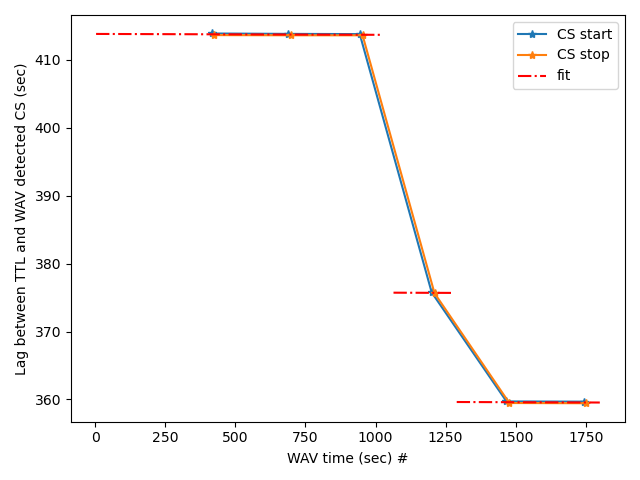

In [30]:
_, ax = plt.subplots(layout='tight')
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)
hl = ax.plot(cs_times_wav, cs_lags_comb, '-*')
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = cs_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(cs_lags_comb.reshape(-1)), cs_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
for nrec in [2, 3, 4]:
    
    wav_times = wav_sync_df.loc[wav_sync_df.nrec == nrec, ["wav_start", "wav_stop"]].values.squeeze()
    hfit = ax.plot(wav_times, wav_sync_df[wav_sync_df.nrec == nrec].p0.values + 
                   wav_sync_df[wav_sync_df.nrec == nrec].p1.values*wav_times, 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [31]:
def get_rec_num(rec_sync_df, times):
    """Identify in which recording each time in times occurs"""
    bins = np.sort(rec_sync_df.loc[:, ["wav_start", "wav_stop"]].values.flatten("C"))
    bin_loc = np.digitize(times, bins)
    indx_bool = bin_loc % 2 == 1
    indx_bool = bin_loc % 2 == 1
    indx_good = np.where(indx_bool)
    indx_bad = np.where(~indx_bool)
    
    nrec_ids = np.ones_like(indx_bool, dtype='int')
    bin_ind = (bin_loc / 2).astype(int)
    if np.any(indx_good):
        nrec_ids[indx_good] = rec_sync_df.loc[bin_ind[indx_good], "nrec"].values
    
    if np.any(indx_bad):
        nrec_ids[indx_bad] = -1

    return nrec_ids

In [32]:
from copy import deepcopy

def wav_epochs_to_eeg(wav_epochs_df, wav_sync_df):
    """wav_epochs_df must have start and stop field for each index"""
    wav_epochs_df2 = deepcopy(wav_epochs_df)
    nrec_start = get_rec_num(wav_sync_df, wav_epochs_df2.start)
    nrec_stop = get_rec_num(wav_sync_df, wav_epochs_df2.stop)
    nrec_bool = nrec_start == nrec_stop
    nrec_good = np.ones_like(nrec_start) * -1
    nrec_good[nrec_bool] = nrec_start
    wav_epochs_df2.insert(wav_epochs_df2.shape[1], column="nrec", value=nrec_good)

    # Initialize default values for t_starts and t_stops
    t_starts = [None] * len(wav_epochs_df2)
    t_stops = [None] * len(wav_epochs_df2)
    
    for idx, it in enumerate(wav_epochs_df2.itertuples()):
        p_use = wav_sync_df.loc[wav_sync_df.nrec == it.nrec, ["p0", "p1"]].values.squeeze()
        if p_use.size > 0:
            t_start = it.start + p_use[0] + p_use[1] * it.start
            t_stop = it.stop + p_use[0] + p_use[1] * it.stop
            t_starts[idx] = t_start
            t_stops[idx] = t_stop
    
    wav_epochs_df2.insert(wav_epochs_df2.shape[1], "t_start_eeg", t_starts)
    wav_epochs_df2.insert(wav_epochs_df2.shape[1], "t_stop_eeg", t_stops)
    
    return wav_epochs_df2

In [33]:
# Sanity check code to output corrected CS times from WAV file to Neuroscope
cs_wav_epochs_aligned = wav_epochs_to_eeg(cs_wav_epochs.to_dataframe(), wav_sync_df)
cs_wav_epochs_aligned = Epoch({"start": cs_wav_epochs_aligned.t_start_eeg.values, 
                               "stop": cs_wav_epochs_aligned.t_stop_eeg.values, 
                               "label": ["CS+ from WAV file"]*cs_wav_epochs_aligned.shape[0]})


cs_epochs_files = sess.filePrefix.with_suffix(".cs_wav_epochs.npy")
cs_wav_epochs_aligned.save(cs_epochs_files)
sess.recinfo.write_epochs(cs_wav_epochs_aligned, ext="wv+")

/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.cs_wav_epochs.npy saved


## Now correct that drift and find corrected lags!

In [34]:
# This should eventually be folded into the DeepSqueakIO class!
# Bowen question: 
calls_accept_df = ds_calls.usv_df[ds_calls.usv_df['Accept'] == 1]
call_starts_wav = calls_accept_df['Begin_Time'].values
call_stops_wav = call_starts_wav + calls_accept_df['Duration'].values
calls_accept_df.insert(0, "start", call_starts_wav)
calls_accept_df.insert(1, "stop", call_stops_wav)
calls_accept_df.insert(calls_accept_df.shape[1], "label", "")
calls_accept_df = wav_epochs_to_eeg(calls_accept_df, wav_sync_df)
good_calls = Epoch(calls_accept_df)

# output to neuroscope and neuropy
sess.recinfo.write_epochs(good_calls, ext="usv")
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
good_calls.save(usv_epochs_file)
good_calls.to_dataframe().sample(10)

/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.usv_epochs.npy saved


,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label,nrec,t_start_eeg,t_stop_eeg,duration
91,1236.483478,1237.028690,1236.483478,16.277778,0.545212,6.555556,1.000000,1,,3,1612.183955,1612.729086,0.545212
42,472.282122,473.587801,472.282122,18.841838,1.305679,15.198167,0.590221,1,,2,886.057849,887.363361,1.305679
43,473.732556,473.774700,473.732556,37.272478,0.042144,25.811404,1.000000,1,,2,887.508098,887.550236,0.042144
33,467.153769,467.208209,467.153769,39.501645,0.054440,7.626096,1.000000,1,,2,880.930150,880.984583,0.054440
78,982.870102,983.294912,982.870102,15.722222,0.424810,4.555556,1.000000,1,,2,1396.580645,1397.005401,0.424810
51,488.807437,490.112468,488.807437,16.934278,1.305032,13.556558,0.590221,1,,2,902.581054,903.885919,1.305032
48,478.903605,479.962644,478.903605,14.115263,1.059039,15.272480,0.590221,1,,2,892.678487,893.737391,1.059039
70,738.883746,738.911585,738.883746,39.055556,0.027839,8.333333,1.000000,1,,2,1152.625437,1152.653273,0.027839
81,984.814742,985.360220,984.814742,14.500000,0.545478,7.333333,1.000000,1,,2,1398.525037,1399.070445,0.545478
39,470.809778,470.893771,470.809778,27.304124,0.083993,9.069874,0.590221,1,,2,884.585693,884.669675,0.083993


## Save notebook to working directory

In [35]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [36]:
pip install jupyter-save-load-vars

Note: you may need to restart the kernel to use updated packages.
